In [1]:
import numpy as np
import pandas as pd
import re
import pickle
import gc

# scikit-learn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# LightGBM
# !pip install lightgbm==3.2.1  #LightGBMバージョン指定（書籍の再現性のため）
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
#メモリ削減の為の関数
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            pass

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
import joblib
import pandas as pd
import numpy as np
import os

# 推論関数の定義
def predict_lgb_regression(input_x,
                input_id,
                list_nfold=[0,1,2,3,4],
                model_dir="models",  # モデル保存ディレクトリ
               ):
    """
    複数のfoldで学習したモデルを使って推論を行う関数

    Parameters:
    - input_x: 推論に使用する説明変数
    - input_id: 推論対象のID（結果と一緒に結合するため）
    - list_nfold: 使用するfoldのリスト（デフォルトは[0,1,2,3,4]）
    - model_dir: モデルを格納したディレクトリ（デフォルトは"models"）

    Returns:
    - 推論結果のデータフレーム
    """
    # 推論結果を格納する配列
    pred = np.zeros((len(input_x), len(list_nfold)))
    
    # 各foldごとにモデルを読み込み、推論を行う
    for nfold in list_nfold:
        print("-" * 20, f"Fold {nfold}", "-" * 20)
        fname_lgb = os.path.join(model_dir, f"model_lgb_fold{nfold}.joblib")
        
        # モデルが存在しない場合のエラーハンドリング
        if not os.path.exists(fname_lgb):
            raise FileNotFoundError(f"Model file not found: {fname_lgb}")
        
        # モデル読み込み
        model = joblib.load(fname_lgb)
        
        # 推論
        pred[:, nfold] = model.predict(input_x)
    
    # 各foldの予測値の平均を計算
    pred_df = pd.concat([
        input_id,
        pd.DataFrame({"pred": pred.mean(axis=1)})
    ], axis=1)
    
    print("Inference completed.")
    
    return pred_df


In [4]:
# ファイルの読み込み
test = pd.read_csv("test.csv")
test = reduce_mem_usage(test)


Memory usage of dataframe is 20.98 MB
Memory usage after optimization is: 14.78 MB
Decreased by 29.5%


In [ ]:
#欠損値を中央値で補完
test['Episode_Length_minutes'].fillna(test['Episode_Length_minutes'].median(), inplace=True)
test["Guest_Popularity_percentage"].fillna(test["Guest_Popularity_percentage"].median(), inplace=True)


In [6]:
#モデル推論 モデル学習が終わったために、そのモデルを使って、推論処理を行う

# データセットの作成
x_test = test[["Host_Popularity_percentage","Episode_Length_minutes", "Guest_Popularity_percentage"]]
# idの取得
id_test = test[["id"]]

# カテゴリ変数をcategory型に変換
for col in x_test.columns:
    if x_test[col].dtype=="O":
        x_test[col] = x_test[col].astype("category")

In [7]:
test.shape

(250000, 11)

In [8]:
#推論処理の実行
test_pred = predict_lgb_regression(x_test,
                        id_test,
                        list_nfold=[0,1,2,3,4],
                        model_dir="models"
                        )

-------------------- Fold 0 --------------------
-------------------- Fold 1 --------------------
-------------------- Fold 2 --------------------
-------------------- Fold 3 --------------------
-------------------- Fold 4 --------------------
Inference completed.


In [9]:
df_submit = test_pred.rename(columns={"pred":"Listening_Time_minutes"})
print(df_submit.shape)
display(df_submit.head())

# ファイル出力
df_submit.to_csv("submission_baseline.csv", index=None)

(250000, 2)


,id,Listening_Time_minutes
0,750000,55.220811
1,750001,17.330274
2,750002,47.960500
3,750003,78.475030
4,750004,48.684896


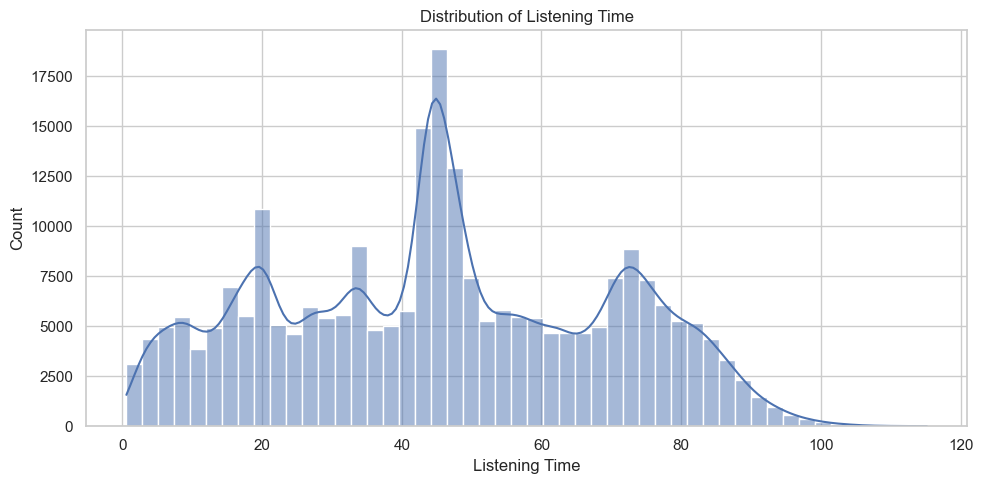

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# seabornのスタイル設定（見やすく）
sns.set(style="whitegrid")

# listening_timeのヒストグラム
plt.figure(figsize=(10, 5))
sns.histplot(df_submit["Listening_Time_minutes"], bins=50, kde=True)
plt.title("Distribution of Listening Time")
plt.xlabel("Listening Time")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


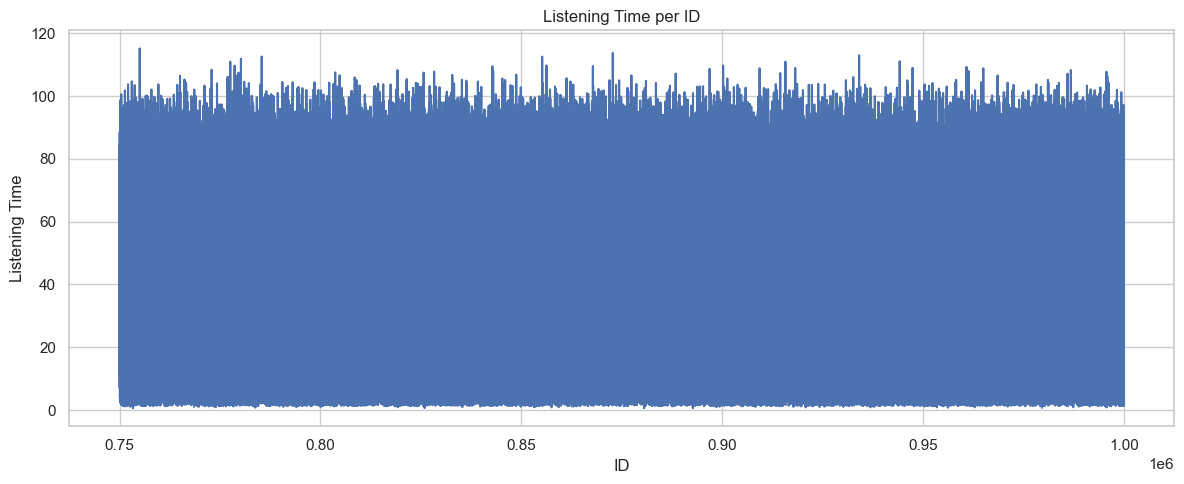

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(df_submit["id"], df_submit["Listening_Time_minutes"])
plt.title("Listening Time per ID")
plt.xlabel("ID")
plt.ylabel("Listening Time")
plt.tight_layout()
plt.show()
